In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")


In [2]:
df = pd.read_csv("actions.csv", nrows=300000)
print("Loaded rows:", len(df))
df.head()


Loaded rows: 300000


,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,0,2500089,1,2.763597,1659,9637,52.50,34.00,63.00,30.60,251700146.0,0,0,1,0,pass,success,foot
1,1,2500089,1,4.761353,1659,8351,63.00,30.60,64.05,10.20,251700147.0,0,0,1,1,pass,success,foot
2,2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,251700148.0,0,0,1,2,pass,success,foot
3,3,2500089,1,7.707561,1659,239411,72.45,20.40,35.70,19.04,251700161.0,0,0,1,3,pass,success,foot
4,4,2500089,1,11.614943,1659,9637,35.70,19.04,30.45,12.24,251700149.0,0,0,1,4,pass,success,foot


In [3]:
game_id = df["game_id"].iloc[0]
game_df = df[df["game_id"] == game_id].copy()

print("Selected Game ID:", game_id)
print("Rows in this game:", len(game_df))


Selected Game ID: 2500089
Rows in this game: 1191


In [8]:
player_counts = game_df["player_id"].value_counts()
selected_player = player_counts.index[0]

player_df = game_df[game_df["player_id"] == selected_player].copy()
player_df = player_df.sort_values("time_seconds")

print("Selected Player:", selected_player)
print("Total Actions:", len(player_df))


Selected Player: 9285
Total Actions: 80


In [9]:
player_df["latency"] = player_df["time_seconds"].diff()
player_df["latency"] = player_df["latency"].fillna(0)

player_df[["time_seconds", "latency"]].head()


,time_seconds,latency
2,5.533097,0.000000
6,17.584257,12.051160
8,21.436162,3.851905
615,29.245621,7.809459
614,29.245621,0.000000


In [10]:
player_df["error"] = np.where(
    player_df["result_name"] == "success", 0, 1
)

player_df[["result_name", "error"]].head()


,result_name,error
2,success,0
6,fail,1
8,fail,1
615,success,0
614,success,0


In [11]:
window_size = 5

player_df["rolling_latency"] = player_df["latency"].rolling(window_size).mean()
player_df["rolling_error_rate"] = player_df["error"].rolling(window_size).mean()

player_df.head(10)


,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,latency,error,rolling_latency,rolling_error_rate
2,2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,...,0,1,2,pass,success,foot,0.000000,0,NaN,NaN
6,6,2500089,1,17.584257,1659,9285,9.45,4.76,8.40,34.00,...,1,0,6,cross,fail,foot,12.051160,1,NaN,NaN
8,8,2500089,1,21.436162,1659,9285,2.10,8.16,2.10,8.16,...,1,0,8,cross,fail,foot,3.851905,1,NaN,NaN
615,615,2500089,2,29.245621,1659,9285,78.75,8.16,60.90,3.40,...,0,1,615,pass,success,foot,7.809459,0,NaN,NaN
614,614,2500089,2,29.245621,1659,9285,78.75,8.16,78.75,8.16,...,10,1,614,interception,success,foot,0.000000,0,4.742505,0.4
10,10,2500089,1,47.760588,1659,9285,22.05,0.00,36.75,21.76,...,2,1,10,throw_in,success,other,18.514967,0,8.445498,0.4
18,18,2500089,1,65.812614,1659,9285,53.55,6.80,40.95,11.56,...,0,1,18,pass,success,foot,18.052026,0,9.645671,0.2
632,632,2500089,2,151.001445,1659,9285,47.25,8.84,67.20,23.80,...,0,1,632,pass,success,foot,85.188831,0,25.913057,0.0
644,644,2500089,2,179.402767,1659,9285,86.10,2.72,78.75,11.56,...,0,1,644,pass,success,foot,28.401322,0,30.031429,0.0
47,47,2500089,1,243.429400,1659,9285,30.45,0.00,31.50,12.24,...,2,1,47,throw_in,success,other,64.026633,0,42.836756,0.0


In [13]:
window_size = 5
rolling_entropy = []

for i in range(len(player_df)):
    if i < window_size - 1:
        rolling_entropy.append(np.nan)
    else:
        window = player_df["type_name"].iloc[i-window_size+1:i+1]
        probs = window.value_counts(normalize=True)
        ent = -np.sum(probs * np.log2(probs + 1e-9))
        rolling_entropy.append(ent)

player_df["rolling_entropy"] = rolling_entropy


In [14]:
player_df = player_df.dropna()

print("Rows after cleaning:", len(player_df))


Rows after cleaning: 73


In [15]:
baseline_df = player_df[player_df["time_seconds"] <= 600]

# Fallback if no data in first 10 minutes
if len(baseline_df) < 5:
    cutoff = int(len(player_df) * 0.2)
    baseline_df = player_df.iloc[:cutoff]

baseline_latency = baseline_df["rolling_latency"].mean()
baseline_error = baseline_df["rolling_error_rate"].mean()
baseline_entropy = baseline_df["rolling_entropy"].mean()

print("Baseline Latency:", round(baseline_latency, 3))
print("Baseline Error:", round(baseline_error, 3))
print("Baseline Entropy:", round(baseline_entropy, 3))


Baseline Latency: 26.81
Baseline Error: 0.188
Baseline Entropy: 1.231


In [16]:


player_df["latency_drift"] = (
    (player_df["rolling_latency"] - baseline_latency) / baseline_latency
)

player_df["error_drift"] = (
    (player_df["rolling_error_rate"] - baseline_error) / baseline_error
)

player_df["entropy_drift"] = (
    (baseline_entropy - player_df["rolling_entropy"]) / baseline_entropy
)

player_df = player_df.replace([np.inf, -np.inf], 0).fillna(0)


In [17]:
player_df["CFI"] = (
    0.4 * player_df["latency_drift"] +
    0.4 * player_df["error_drift"] +
    0.2 * player_df["entropy_drift"]
) * 100

player_df["CFI"] = player_df["CFI"].clip(lower=0)

print("Current CFI:", round(player_df["CFI"].iloc[-1], 2))


Current CFI: 27.47


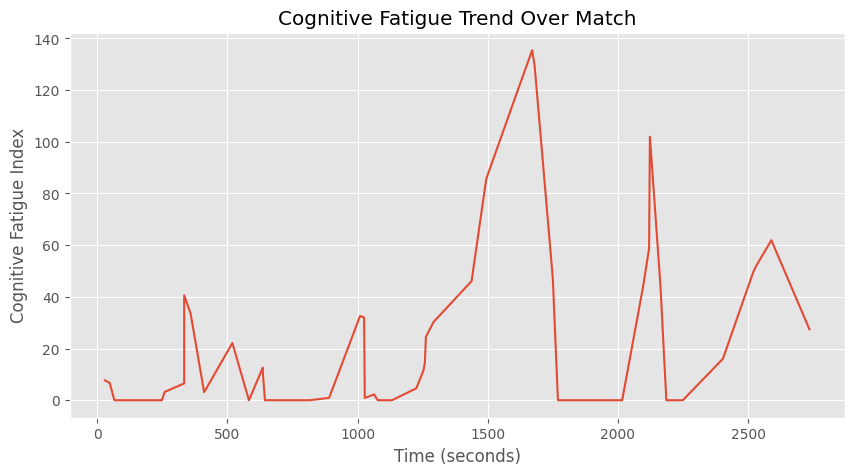

In [18]:
plt.figure(figsize=(10,5))
plt.plot(player_df["time_seconds"], player_df["CFI"])
plt.xlabel("Time (seconds)")
plt.ylabel("Cognitive Fatigue Index")
plt.title("Cognitive Fatigue Trend Over Match")
plt.show()


In [19]:
player_df["CFI"] = player_df["CFI"].clip(0, 100)


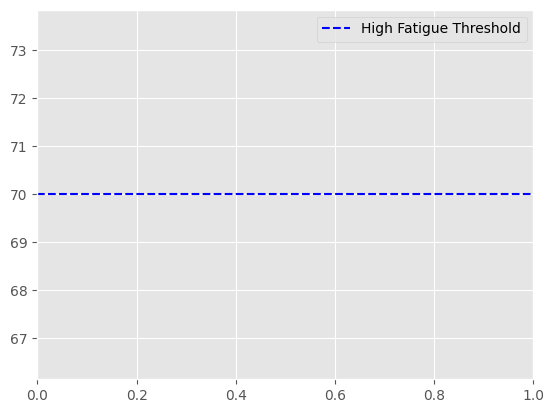

In [20]:
plt.axhline(y=70, color='blue', linestyle='--', label='High Fatigue Threshold')
plt.legend()


In [21]:
if player_df["CFI"].iloc[-1] > 70:
    print("⚠ High Fatigue Risk Detected")
else:
    print("Player in Stable Cognitive State")


Player in Stable Cognitive State


In [22]:
recent_cfi = player_df["CFI"].tail(5).mean()

if recent_cfi > 70:
    print("⚠ Sustained High Fatigue Risk Detected")
else:
    print("Player in Stable Cognitive State")


Player in Stable Cognitive State


In [23]:
player_df["CFI"] = player_df["CFI"].clip(0, 100)


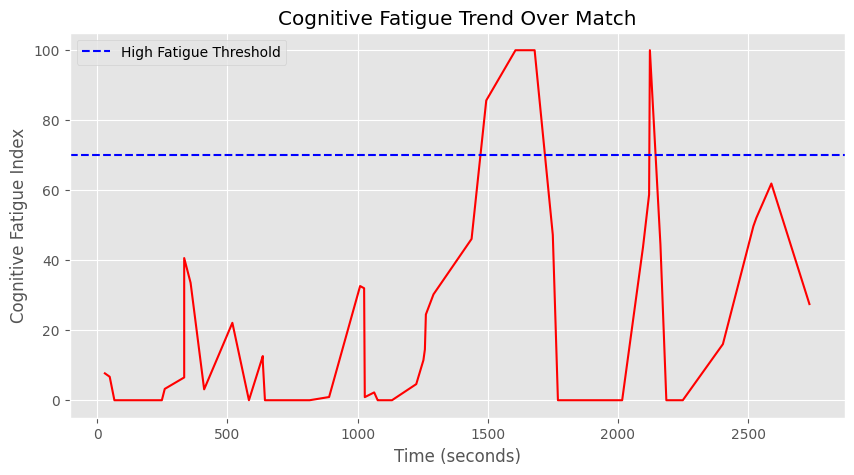

In [24]:
plt.figure(figsize=(10,5))
plt.plot(player_df["time_seconds"], player_df["CFI"], color="red")
plt.axhline(y=70, color="blue", linestyle="--", label="High Fatigue Threshold")
plt.xlabel("Time (seconds)")
plt.ylabel("Cognitive Fatigue Index")
plt.title("Cognitive Fatigue Trend Over Match")
plt.legend()
plt.show()


In [25]:
print("----- MATCH SUMMARY -----")
print("Selected Player:", selected_player)
print("Baseline Latency:", round(baseline_latency,2))
print("Baseline Error Rate:", round(baseline_error,2))
print("Baseline Entropy:", round(baseline_entropy,2))
print("Final Fatigue Score:", round(player_df["CFI"].iloc[-1],2))


----- MATCH SUMMARY -----
Selected Player: 9285
Baseline Latency: 26.81
Baseline Error Rate: 0.19
Baseline Entropy: 1.23
Final Fatigue Score: 27.47
